## 0. Import Libraries

In [2]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import matplotlib
import salem
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize
from wrf import getvar, interpline, CoordPair, xy_to_ll, ll_to_xy 

import warnings
warnings.filterwarnings('ignore')

In [3]:
def merge_cs_members(data_path):
    
    # open data
    dts = []
    for i in data_path:
        dt_ = xr.open_dataset(i)[variable].isel(cross_line_idx=slice(0, 78))
        dts.append(dt_)
    
    return xr.concat(dts, dim='cs_member')

In [4]:
def average_cs_members(microphysics):
    
    dt_var = {}

    for u in ['_urban', '_nourban']:

        # data path
        data_path = glob(fr'{general_path}/*{run_data}**{microphysics}**{u}**{variable}**{cs_type}*')

        dts = merge_cs_members(data_path).mean(dim='cs_member').squeeze()
        dt_var[u[1:]] = dts
        
    return dt_var

## 1. Open Data

### 1.1 ERA5

#### 1.1.1 European Side

##### 1.1.1.1 wa

In [27]:
run_data = 'era5'
variable = 'wa'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]
cs_type = 'eu'

In [28]:
dt_wa_era5_urban_ens_eu = xr.concat([average_cs_members('LIN')['urban'],
                              average_cs_members('THOMPSON')['urban'],
                              average_cs_members('WSM6')['urban']], 
                              dim='ens').mean(dim='ens')

dt_wa_era5_nourban_ens_eu = xr.concat([average_cs_members('LIN')['nourban'],
                              average_cs_members('THOMPSON')['nourban'],
                              average_cs_members('WSM6')['nourban']], 
                              dim='ens').mean(dim='ens')

#### 1.1.2 Anatolian Side

##### 1.1.2.1 wa

In [29]:
run_data = 'era5'
variable = 'wa'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]
cs_type = 'an'

In [30]:
dt_wa_era5_urban_ens_an = xr.concat([average_cs_members('LIN')['urban'],
                              average_cs_members('THOMPSON')['urban'],
                              average_cs_members('WSM6')['urban']], 
                              dim='ens').mean(dim='ens')

dt_wa_era5_nourban_ens_an = xr.concat([average_cs_members('LIN')['nourban'],
                              average_cs_members('THOMPSON')['nourban'],
                              average_cs_members('WSM6')['nourban']], 
                              dim='ens').mean(dim='ens')

### 1.2 GFS

#### 1.2.1 European Side

##### 1.2.1.1 wa

In [31]:
run_data = 'gfs'
variable = 'wa'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]
cs_type = 'eu'

In [32]:
dt_wa_gfs_urban_ens_eu = xr.concat([average_cs_members('LIN')['urban'],
                              average_cs_members('THOMPSON')['urban'],
                              average_cs_members('WSM6')['urban']], 
                              dim='ens').mean(dim='ens')

dt_wa_gfs_nourban_ens_eu = xr.concat([average_cs_members('LIN')['nourban'],
                              average_cs_members('THOMPSON')['nourban'],
                              average_cs_members('WSM6')['nourban']], 
                              dim='ens').mean(dim='ens')

#### 1.2.2 Anatolian Side

##### 1.2.2.1 wa

In [33]:
run_data = 'gfs'
variable = 'wa'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]
cs_type = 'an'

In [34]:
dt_wa_gfs_urban_ens_an = xr.concat([average_cs_members('LIN')['urban'],
                              average_cs_members('THOMPSON')['urban'],
                              average_cs_members('WSM6')['urban']], 
                              dim='ens').mean(dim='ens')

dt_wa_gfs_nourban_ens_an = xr.concat([average_cs_members('LIN')['nourban'],
                              average_cs_members('THOMPSON')['nourban'],
                              average_cs_members('WSM6')['nourban']], 
                              dim='ens').mean(dim='ens')

## 3. Visualization

### 3.1 Options

In [67]:
def plot_hourly_cs(dt_urban, dt_nourban,
                   d_type, cs_type,
                   fig_array, graphic_no,
                   cmap, norm, var, ticks):
    
    # Create Figure -------------------------
    fig, axs = proplot.subplots(fig_array, 

                                includepanels=True,
                                hspace=0.86,
                                wspace=0.86,
                                sharey=3)

    # format whole figure
    axs.format(abcloc='ul',
               abc=True,)

    axs.format(
                #collabels=['h1', 'h2', 'h3', 'h4', 'h5', 'h6'],
               rowlabels=['urban', 'nourban']
               )

    axs.format(ylim=(1000, 200), yscale='log',
               ylabel='Pressure (hPa)', ylocator=100,
               xlabel='Coordinate (index)')

    x_fill = [20, 30, 40, 50]
    y_fill = [800, 800, 800, 800]

    for t in range(graphic_no):

        if t < graphic_no/2:
            dt_ens = dt_urban

            i = t
        else:
            dt_ens = dt_nourban

            i = t-int(graphic_no/2)


        cut = -0.1
        mesh = axs[t].contourf(dt_ens[i]['cross_line_idx'], 
                        dt_ens[i]['vertical'],#[::-1],
                        dt_ens[i], 
                        cmap = cmap,
                        cmap_kw={'cut': cut},
                        linewidth = 0.1,
                        norm=norm,
                        zorder = 0.2,
                        alpha=1)


    # colorbar
    cbar = fig.colorbar(mesh,
                    label='m/s',
                    ticks = ticks,
                    loc = 'b',
                    shrink = 0.3,
                    width = 0.15,
                    labelsize = 15,
                     ticklabelsize = 15,
                    #col=2
                   )

    #save figure
    plt.savefig(fr'pictures/{d_type}_cs_{cs_type}_{var}_hourly.jpeg',
                bbox_inches='tight', optimize=True,
                progressive=True, dpi=1000)

In [35]:
bottom_hgt_list = []
dt_tempor = dt_wa_gfs_urban_ens[0]
for i in range(len(dt_tempor['cross_line_idx'])):
    
    bottom_hgt_list.append(float(dt_tempor.sel(cross_line_idx=i).dropna(dim='vertical')[0]['vertical'].values))

In [53]:
# Parameters to change (plot) -------------------
cmap = proplot.Colormap('Balance')

# fig features
fig_array = [[1,2,3,4,5,6],
             [7,8,9,10,11,12]
            ]
graphic_no = 12

# graphic vmin, vmax and norms

clevs_total = np.arange(-6, 6.1, 1)
norm = BoundaryNorm(clevs_total,
                    ncolors=cmap.N, 
                    clip=True)
ticks = np.arange(-6, 6.1, 3)

### 3.2 European Side

#### 3.2.1 ERA5

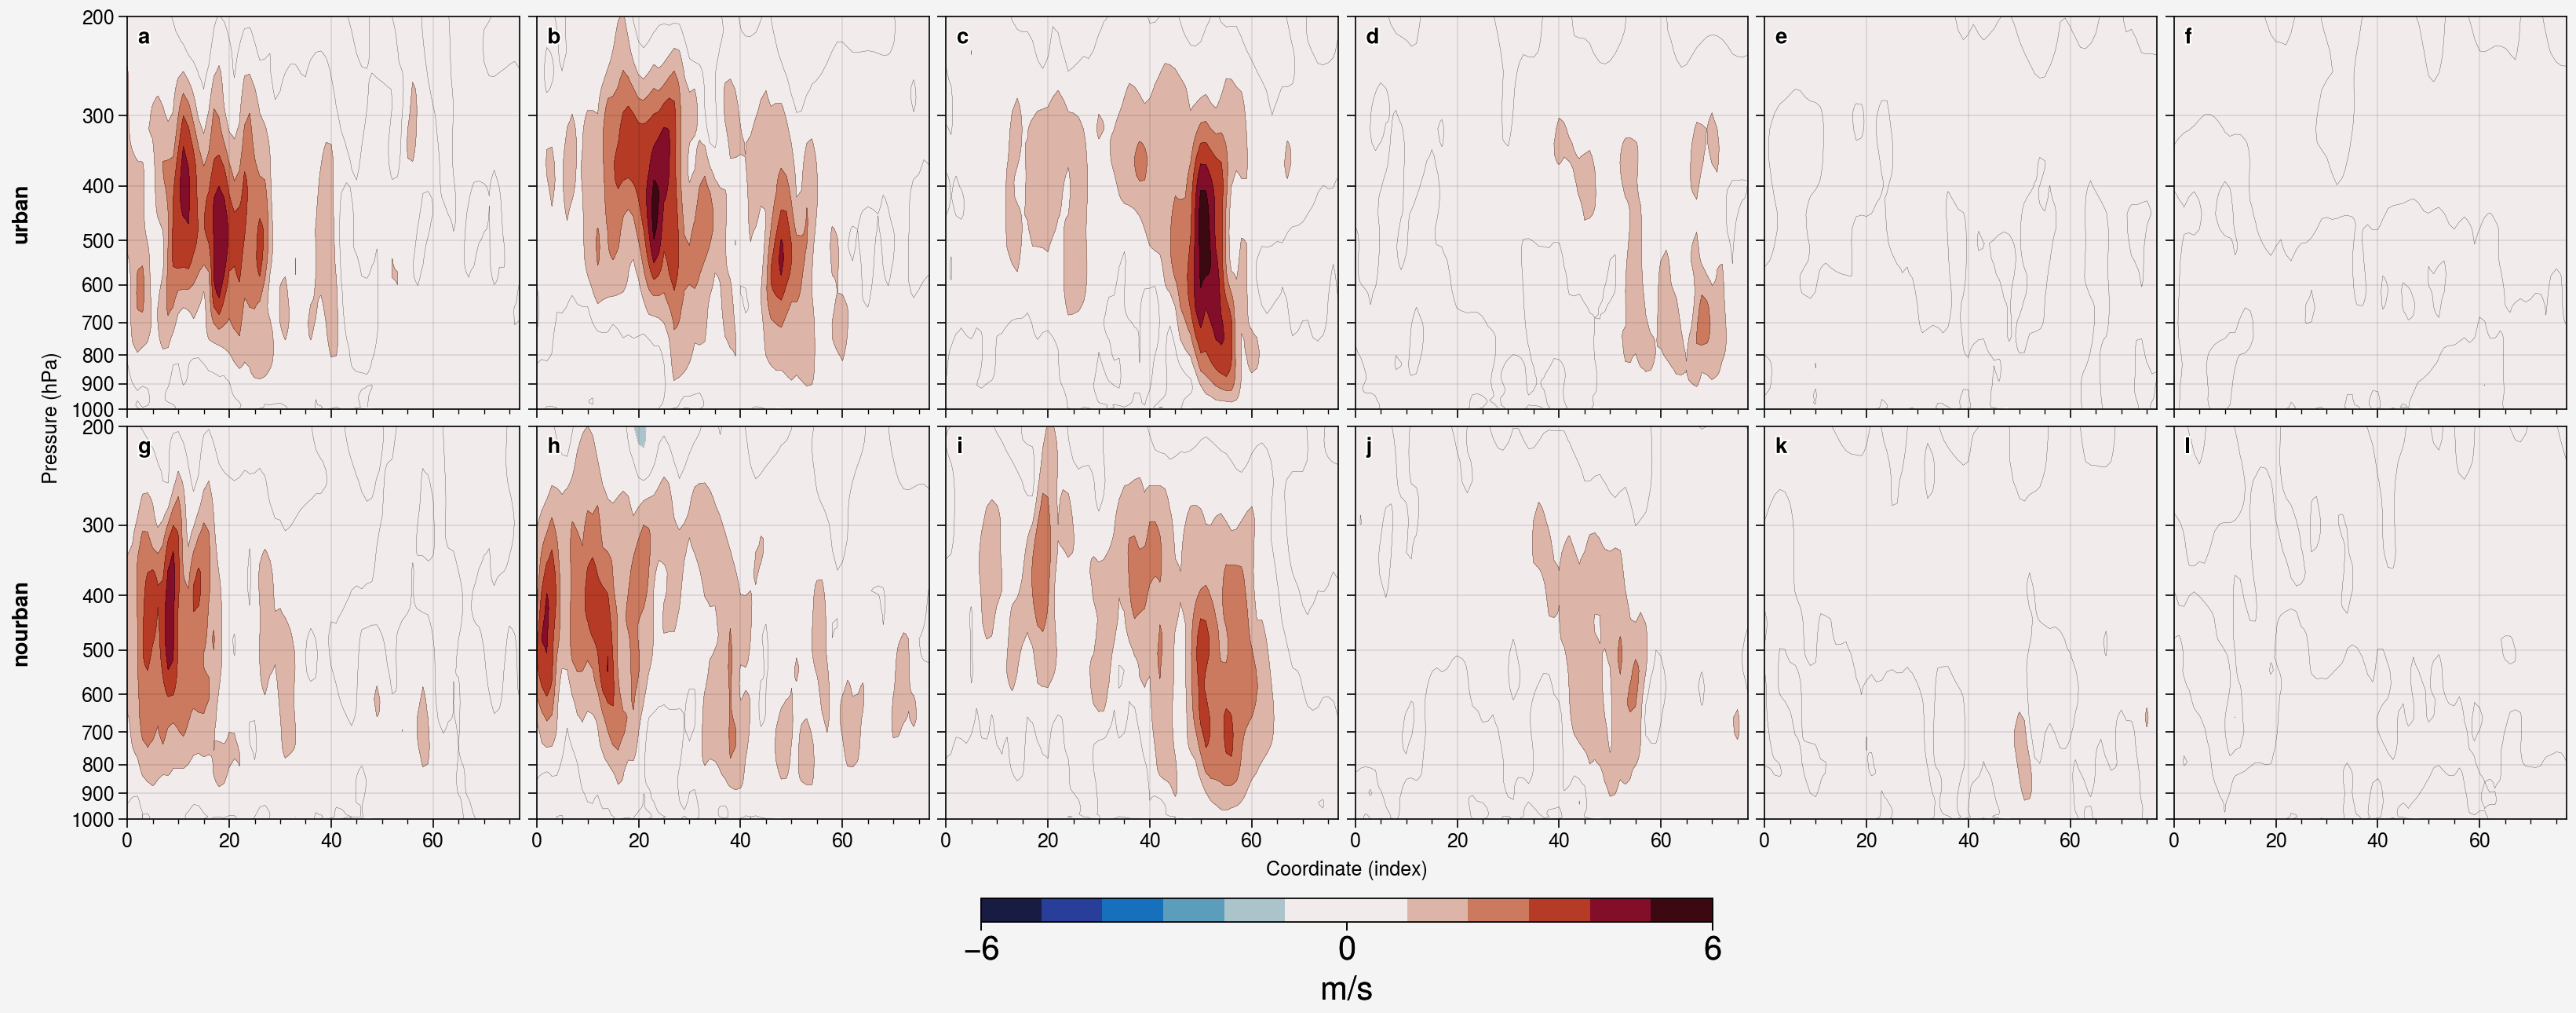

In [68]:
d_type = 'era5'
cs_type = 'eu'
var = 'wa'

plot_hourly_cs(dt_wa_era5_urban_ens_eu, dt_wa_era5_nourban_ens_eu,
               d_type, cs_type, fig_array, graphic_no, cmap, norm, var, ticks)

#### 3.2.2 GFS

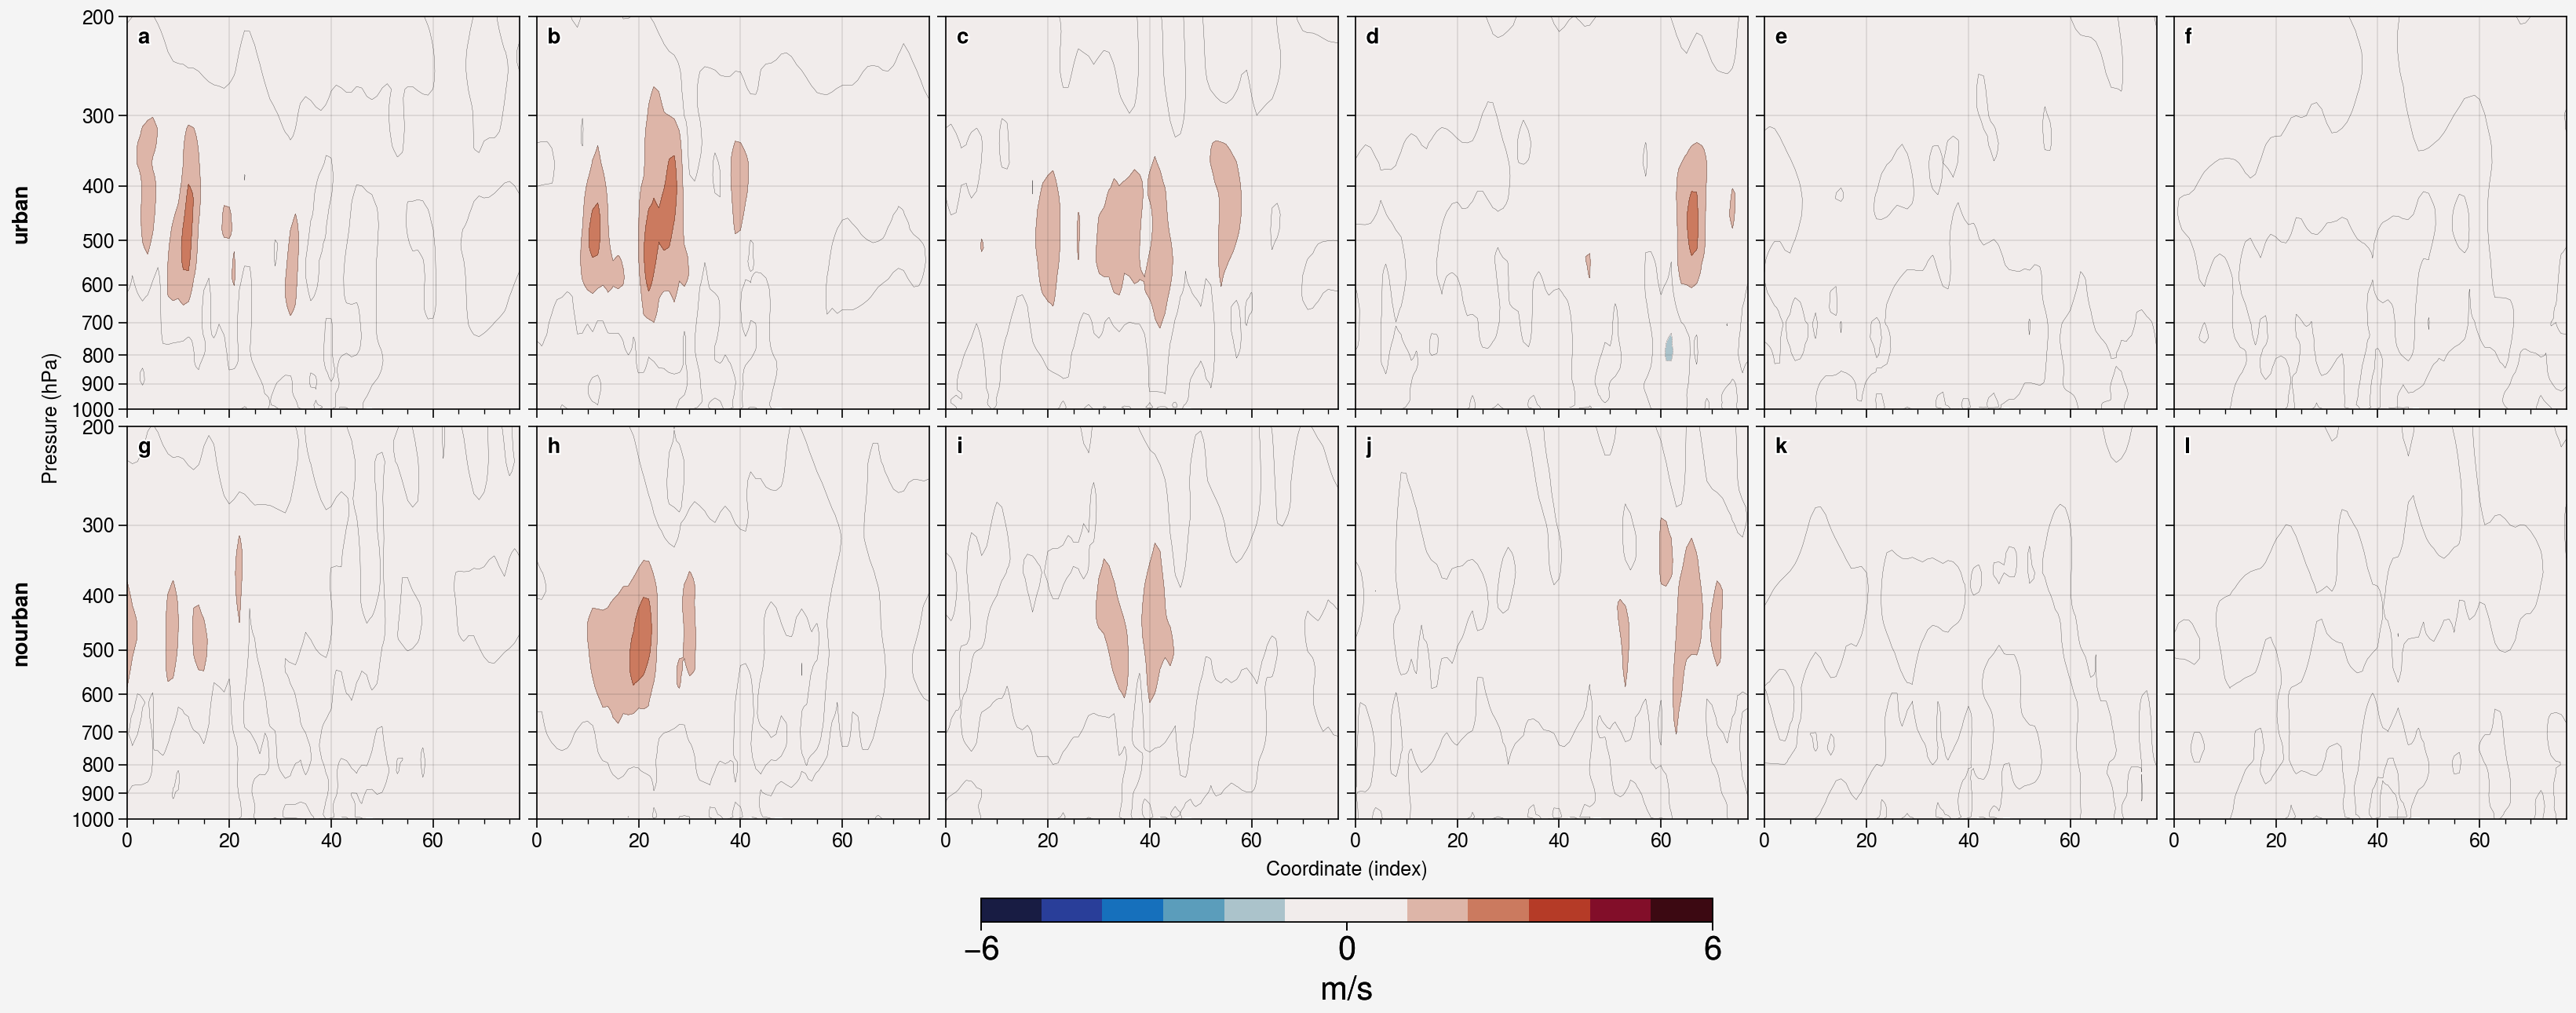

In [69]:
d_type = 'gfs'
cs_type = 'eu'
var = 'wa'

plot_hourly_cs(dt_wa_gfs_urban_ens_eu, dt_wa_gfs_nourban_ens_eu,
               d_type, cs_type, fig_array, graphic_no, cmap, norm, var, ticks)

### 3.3 Anatolian Side

#### 3.3.1 ERA5

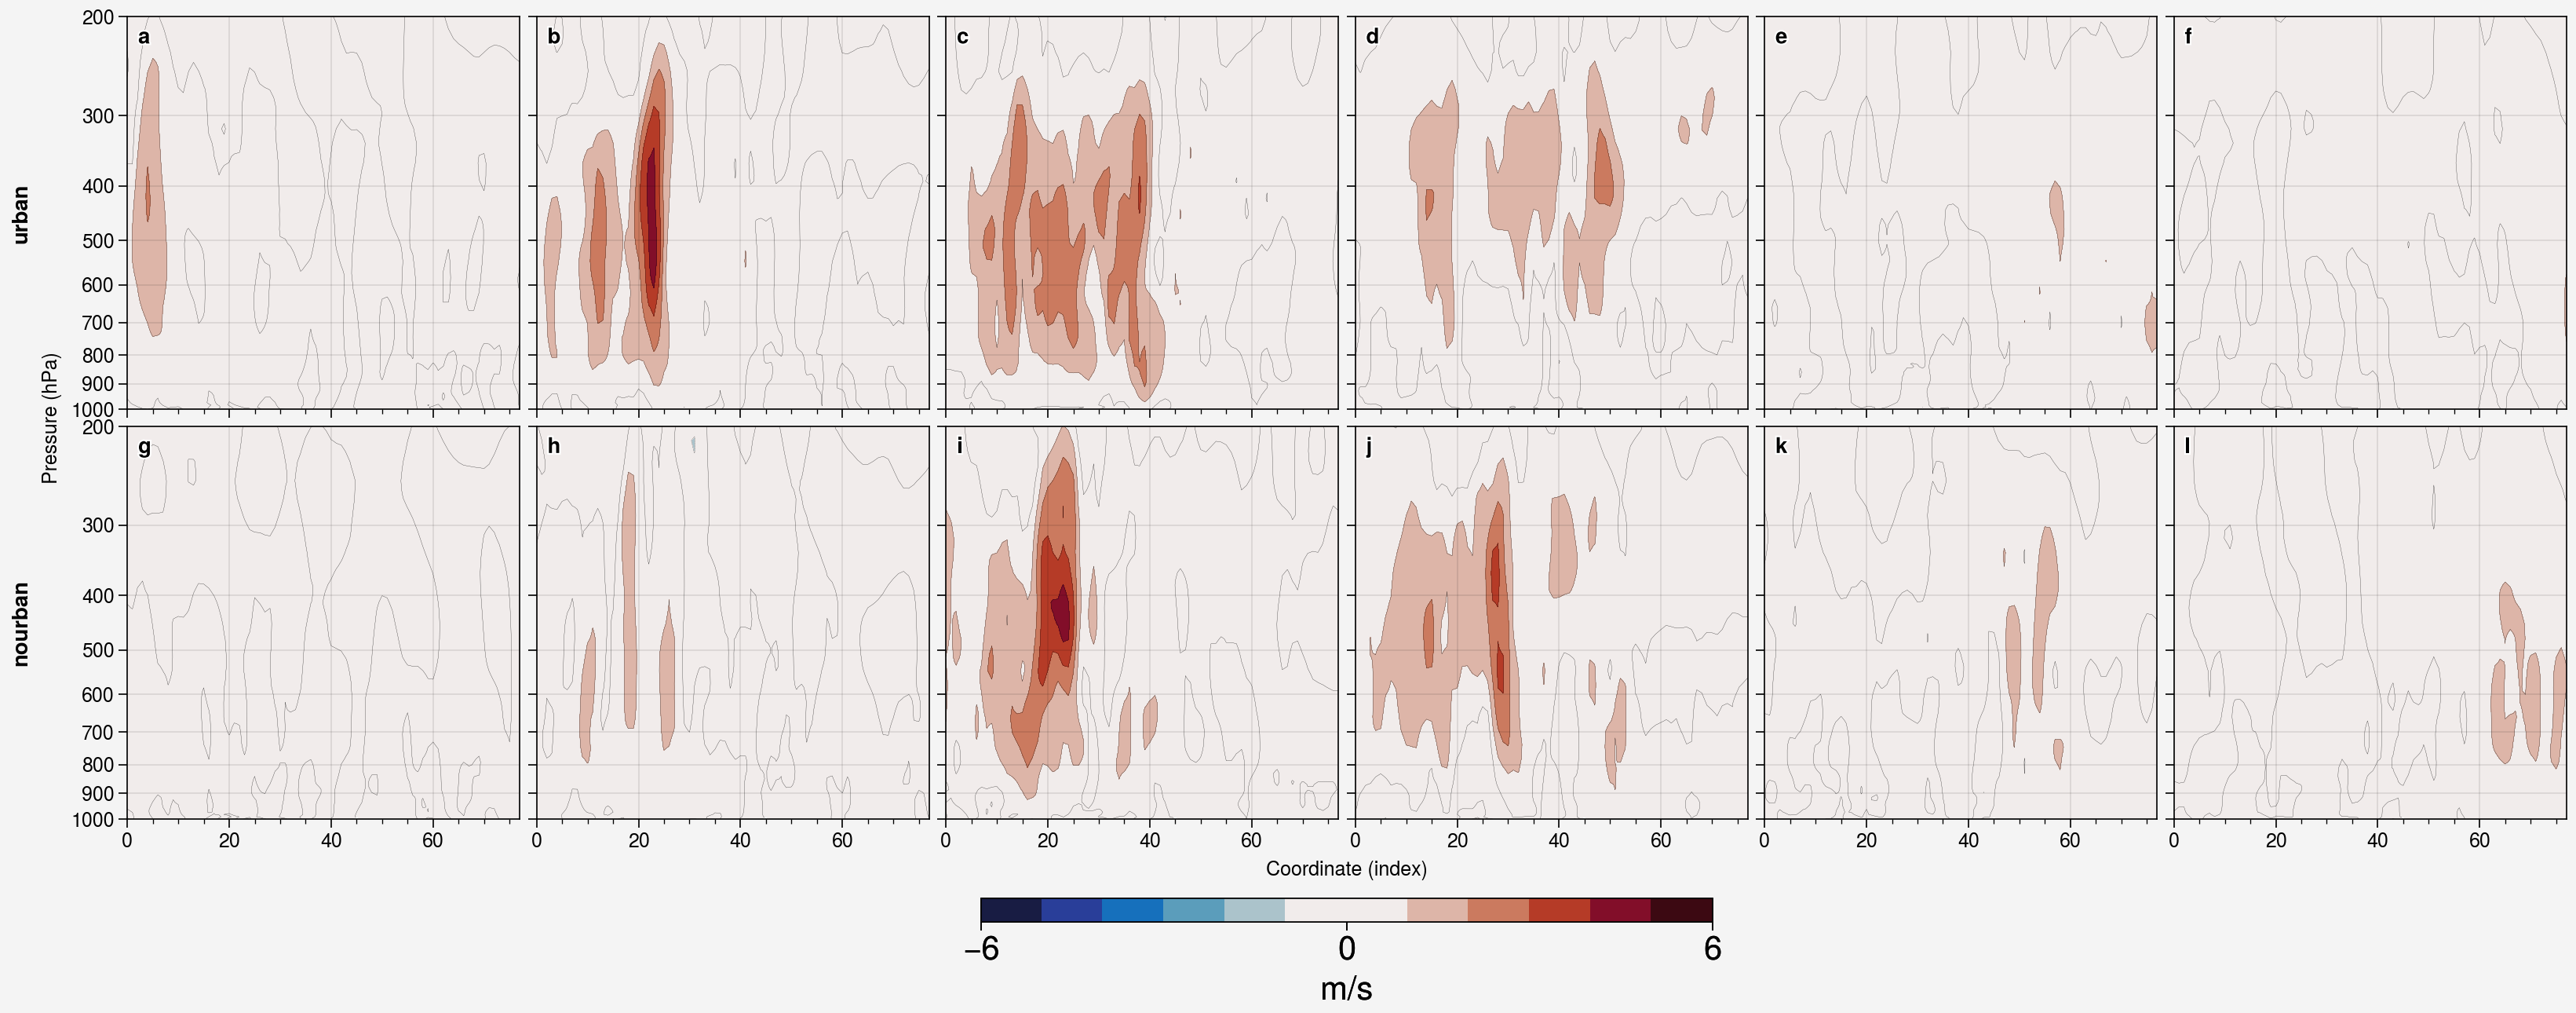

In [70]:
d_type = 'era5'
cs_type = 'an'
var = 'wa'

plot_hourly_cs(dt_wa_era5_urban_ens_an, dt_wa_era5_nourban_ens_an,
               d_type, cs_type, fig_array, graphic_no, cmap, norm, var, ticks)

#### 3.3.2 GFS

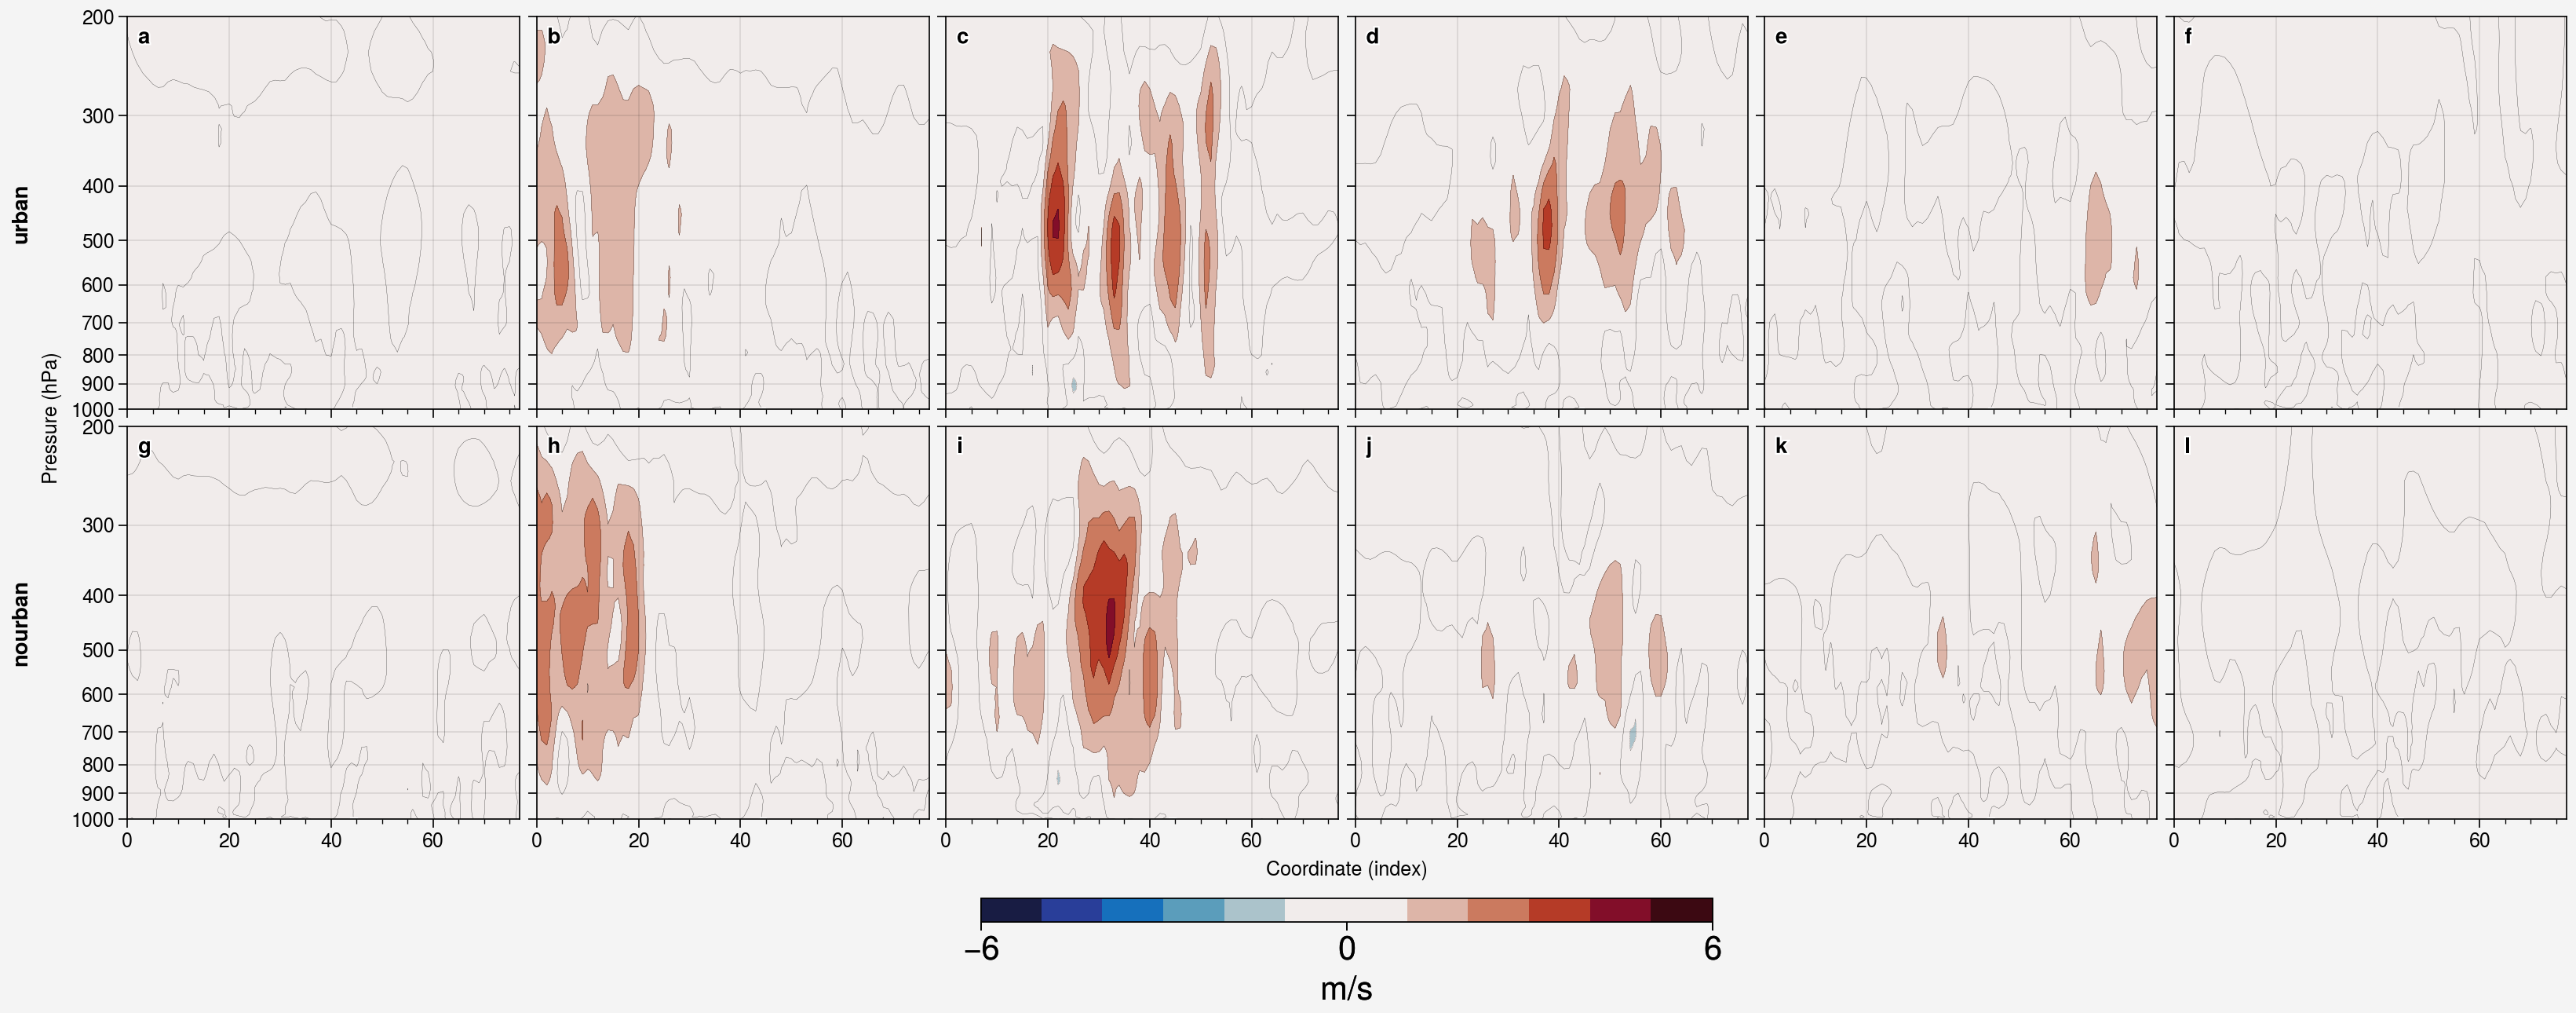

In [71]:
d_type = 'gfs'
cs_type = 'an'
var = 'wa'

plot_hourly_cs(dt_wa_gfs_urban_ens_an, dt_wa_gfs_nourban_ens_an,
               d_type, cs_type, fig_array, graphic_no, cmap, norm, var, ticks)